In [1]:
#!source /data/Xilinx_no_Vitis/Vivado/2020.1/settings64.sh
!vivado -version

Vivado v2020.1.1 (64-bit)
SW Build 2960000 on Wed Aug  5 22:57:21 MDT 2020
IP Build 2956692 on Thu Aug  6 01:41:30 MDT 2020
Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.


In [2]:
import os 
import pickle
import hashlib

import pandas as pd

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
# need updated tensorflow-model-optimization==0.8.0
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2024-10-04 08:18:13.243468: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 08:18:13.246012: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 08:18:13.289636: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 08:18:13.290358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 08:18:13.874380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/giuseppe/miniconda3/envs/ml4qick-env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [3]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

## Setup data

In [4]:
dataset_date = '20230529'
#dataset_date = '20240528'

In [5]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [6]:
#train_data_dir = "../data/malab_05282024/npz/"
#test_data_dir = "../data/malab_05282024/npz/"
train_data_dir = f'../data/qick_data/{dataset_date}/000_770/'
test_data_dir = f'../data/qick_data/{dataset_date}/000_770/'
start_location = 100
end_window = 500
window_size = 400

In [7]:
"""Loadning training split"""
#x_train_path = os.path.join(train_data_dir, f'0528_X_train_0_770.npy')
#y_train_path = os.path.join(train_data_dir, f'0528_y_train_0_770.npy')
x_train_path = os.path.join(train_data_dir, f'X_train_000_770.npy')
y_train_path = os.path.join(train_data_dir, f'y_train_000_770.npy')

assert os.path.exists(x_train_path), f"ERROR: File {x_train_path} does not exist."
assert os.path.exists(y_train_path), f"ERROR: File {y_train_path} does not exist."

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded
if dataset_date == '20240528':
    assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
    assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."
else:
    assert hashlib.md5(X_train_val).hexdigest() == '0ab0f60cc85484a09ac3a963dff3f2b6',  "Checksum failed. Wrong file was loaded or file may be corrupted."
    assert hashlib.md5(y_train_val).hexdigest() == '4fd659c18a973f4742cb25fdca75f8b8',  "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_train_val = X_train_val[:,start_location*2:end_window*2]
y_train_val = one_hot_encode(y_train_val)
assert len(X_train_val[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_train_val[0])} does not match (start window, end window) ({start_location},{end_window}) size."


print("Train Data Set:")
print(f"  X Path : {x_train_path}")
print(f"  y Path : {y_train_path}")
print(f"  Size : {len(X_train_val):,}")
print(f"  Shape : {X_train_val[0].shape}")

Train Data Set:
  X Path : ../data/qick_data/20230529/000_770/X_train_000_770.npy
  y Path : ../data/qick_data/20230529/000_770/y_train_000_770.npy
  Size : 909,000
  Shape : (800,)


In [8]:
"""Loading testing split"""
#x_test_path = os.path.join(test_data_dir, f'0528_X_test_0_770.npy')
#y_test_path = os.path.join(test_data_dir, f'0528_y_test_0_770.npy')
x_test_path = os.path.join(train_data_dir, f'X_test_000_770.npy')
y_test_path = os.path.join(train_data_dir, f'y_test_000_770.npy')

assert os.path.exists(x_test_path), f"ERROR: File {x_test_path} does not exist."
assert os.path.exists(y_test_path), f"ERROR: File {y_test_path} does not exist."

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded
if dataset_date == '20240528':
    assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
    assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."
else:
    assert hashlib.md5(X_test).hexdigest() == '678ec7a77105a7c05d7b269ee0ce57ec', "Checksum failed. Wrong file was loaded or file may be corrupted."
    assert hashlib.md5(y_test).hexdigest() == 'fdc9fe7b08d38399e70824eb131f8d07', "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_test = X_test[:,start_location*2:end_window*2]
y_test = one_hot_encode(y_test)
assert len(X_test[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_test[0])} does not match (start window, end window) ({start_location},{end_window}) size."


print("Test Data Set:")
print(f"  X Path : {x_test_path}")
print(f"  y Path : {y_test_path}")
print(f"  Size : {len(X_test):,}" )
print(f"  Sample Shape : {X_test[0].shape}")

Test Data Set:
  X Path : ../data/qick_data/20230529/000_770/X_test_000_770.npy
  y Path : ../data/qick_data/20230529/000_770/y_test_000_770.npy
  Size : 101,000
  Sample Shape : (800,)


## Build our model 
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models. We're using QDense layer instead of Dense. We're also training with model sparsity, since QKeras layers are prunable.

In [9]:
hidden_neurons = 8
input_shape = int((end_window-start_location)*2)

In [10]:
def get_model(input_shape, hidden=8, is_pruned=True):
    model = keras.models.Sequential()
    model.add(QDense(
        hidden, 
        activation='relu', 
        name='fc1',
        input_shape=(input_shape,), 
        kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1)
    ))
    # model.add(BatchNormalization(name='batchnorm1'))
    model.add(QBatchNormalization(
            name='batchnorm1',
            gamma_quantizer=quantized_bits(6, 0, 1),
            mean_quantizer=quantized_bits(6, 0, 1),
            variance_quantizer=quantized_bits(6, 0, 1),
            beta_quantizer=quantized_bits(6, 0, 1),
    ))
    model.add(
        QDense(2, name='fc2', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1))
    )

    # adding pruning 
    if is_pruned == True:
        pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10, final_sparsity=0.50, begin_step=200, end_step=1000)}
        model = prune.prune_low_magnitude(model, **pruning_params)
    return model


model = get_model(input_shape=input_shape, hidden=hidden_neurons, is_pruned=False)
print(model.summary())
print('Input shape:', input_shape)
print('Number of hidden neurons:', hidden_neurons)

2024-10-04 08:18:41.855441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 08:18:41.865737: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 8)                 6408      
                                                                 
 batchnorm1 (QBatchNormaliz  (None, 8)                 32        
 ation)                                                          
                                                                 
 fc2 (QDense)                (None, 2)                 18        
                                                                 
Total params: 6458 (25.23 KB)
Trainable params: 6442 (25.16 KB)
Non-trainable params: 16 (64.00 Byte)
_________________________________________________________________
None
Input shape: 800
Number of hidden neurons: 8


## Training 

In [11]:
init_learning_rate = 1e-2
validation_split = 0.05  # 45,000 sample size 
batch_size = 1024*8
epochs = 150
early_stopping_patience = 20
checkpoint_dir = f'../checkpoints/scan_window_location_and_size_h{hidden_neurons}'
checkpoint_filename = 'qkeras_model_best.h5'
# checkpoint_filename = 'qkeras_model_best.weights.h5'

assert os.path.exists(checkpoint_dir), f'ERROR: Checkpoint directory {checkpoint_dir} does not exist.'

In [12]:
#########################
# 0. init callbacks
#########################
ckp_dir = os.path.join(checkpoint_dir, f'sl{start_location}_ws{window_size}_date{dataset_date}')
if os.path.exists(ckp_dir) == False: os.mkdir(ckp_dir)
print('Saving to', ckp_dir)

ckp_filename = os.path.join(ckp_dir, checkpoint_filename)
callbacks = [
    ModelCheckpoint(
        ckp_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        save_freq="epoch",
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=False,
    ),
    pruning_callbacks.UpdatePruningStep(),
    # ReduceLROnPlateau(patience=early_stopping_patience, min_delta=1**-6),
]


Saving to ../checkpoints/scan_window_location_and_size_h8/sl100_ws400_date20230529


In [13]:
if True:
    #########################
    # 1. declare model 
    #########################
    opt = Adam(learning_rate=init_learning_rate)
    model = get_model(input_shape=window_size*2, is_pruned=True)
    model.compile(
        optimizer=opt, 
        loss=CategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )

    #########################
    # 3. train 
    #########################
    history = model.fit(
        X_train_val, 
        y_train_val, 
        batch_size=batch_size,
        epochs=epochs, 
        validation_split=validation_split, 
        shuffle=True, 
        callbacks=callbacks,
    )

    # Save the history dictionary
    with open(os.path.join(ckp_dir, 'qkeras_training_history.pkl'), 'wb') as f:
        pickle.dump(history.history, f)

    #########################
    # 3. compute fidelity 
    #########################
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    print('\n===================================')
    print(f'Start location = {start_location}, Window size = {window_size}')
    print('    Accuracy', test_acc)
    print('    Fidelity', test_acc*2-1)


Epoch 1/150
106/106 [==============================] - 3s 11ms/step - loss: 0.2422 - accuracy: 0.9251 - val_loss: 0.2026 - val_accuracy: 0.9424
Epoch 2/150
106/106 [==============================] - 1s 6ms/step - loss: 0.1671 - accuracy: 0.9588 - val_loss: 0.1683 - val_accuracy: 0.9582
Epoch 3/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1647 - accuracy: 0.9600 - val_loss: 0.1746 - val_accuracy: 0.9542
Epoch 4/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9606 - val_loss: 0.1667 - val_accuracy: 0.9594
Epoch 5/150
106/106 [==============================] - 1s 5ms/step - loss: 0.1621 - accuracy: 0.9607 - val_loss: 0.1654 - val_accuracy: 0.9596
Epoch 6/150
106/106 [==============================] - 1s 6ms/step - loss: 0.1624 - accuracy: 0.9606 - val_loss: 0.1652 - val_accuracy: 0.9598
Epoch 7/150
106/106 [==============================] - 1s 6ms/step - loss: 0.1619 - accuracy: 0.9608 - val_loss: 0.1647 - val_accuracy: 0.959

## Check performance

In [14]:
ckp_filename = os.path.join(ckp_dir, checkpoint_filename)
ckp_filename

'../checkpoints/scan_window_location_and_size_h8/sl100_ws400_date20230529/qkeras_model_best.h5'

In [15]:
checkpoint_model = get_model(input_shape=input_shape, hidden=hidden_neurons, is_pruned=True)
checkpoint_model.load_weights(ckp_filename)

y_pred = checkpoint_model.predict(X_test)
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

print(f"Keras  Accuracy: {test_acc}")
print(f"Keras  Fidelity: {test_acc*2-1}")

3157/3157 [==============================] - 4s 1ms/step
Keras  Accuracy: 0.959980198019802
Keras  Fidelity: 0.9199603960396039


## Check sparsity 

Number of layers: 3
% of zeros = 0.5
% of zeros = 0.0
% of zeros = 0.5


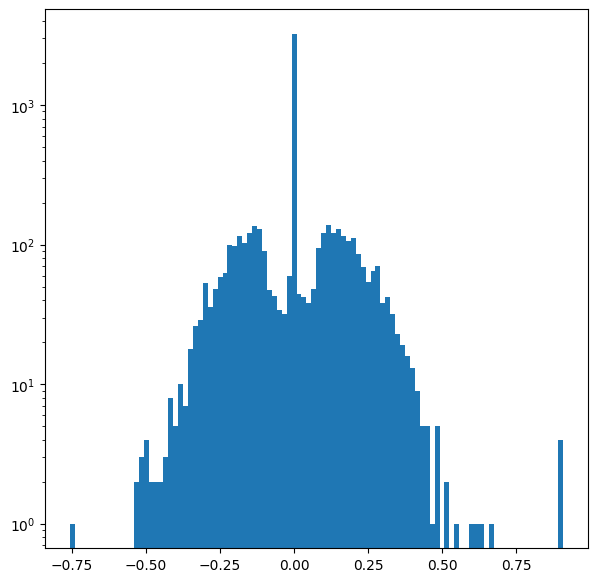

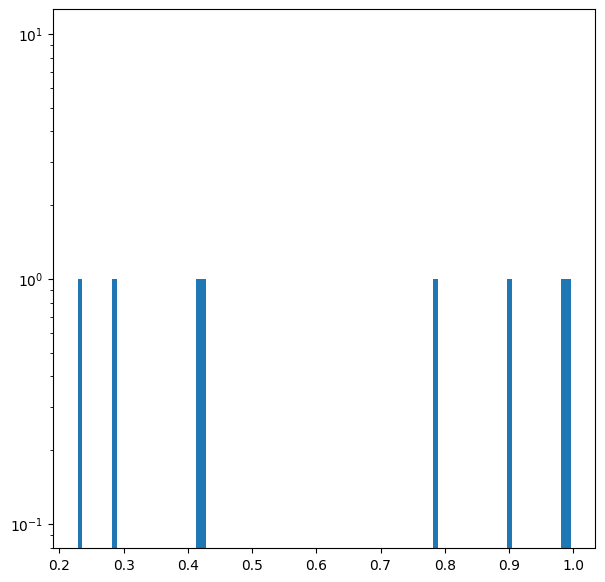

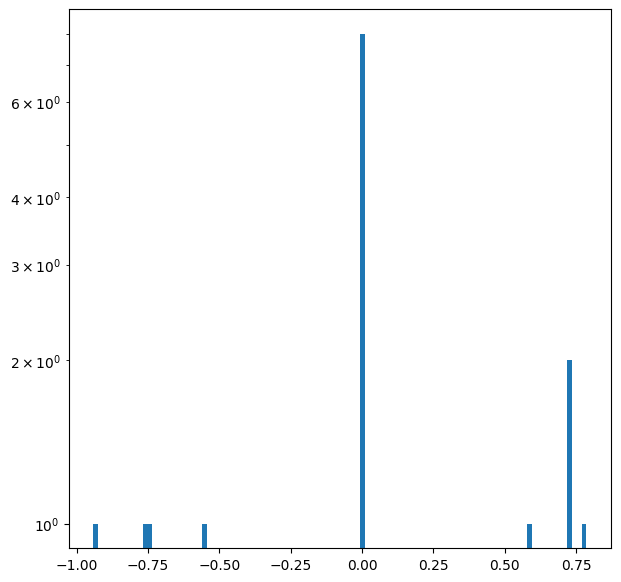

In [16]:
num_layers = len(checkpoint_model.layers)
print(f'Number of layers: {num_layers}')


for idx in range(num_layers):
    w = checkpoint_model.layers[idx].weights[0].numpy()
    h, b = np.histogram(w, bins=100)

    # plot weight distribution
    plt.figure(figsize=(7, 7))
    plt.bar(b[:-1], h, width=b[1] - b[0])
    plt.semilogy()
    plt.savefig(f'model-dist-idx{idx}.png')

    print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))


checkpoint_model = strip_pruning(checkpoint_model)  # remove prune layers for hls4ml parsing 
checkpoint_model.save_weights(ckp_filename)  # save as weights only for keras tracing (cannot directly pass strip_pruned model)
checkpoint_model = get_model(input_shape=input_shape, hidden=hidden_neurons, is_pruned=False)
checkpoint_model.load_weights(ckp_filename)

## HLS4ML

In [17]:
import sys 
sys.path.append("../utils")
from config import print_dict

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

In [18]:
# Create HLS configuration 
hls_config = {}
hls_config['Model'] = {}
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision
#hls_config['Model']['ReuseFactor'] = 1  # fully parallelized 
hls_config['Model']['ReuseFactor'] = 64
hls_config['Model']['Strategy'] = 'Resource'

hls_config['LayerName'] = {}
keras_layers = ['fc1', 'fc1_relu', 'batchnorm1', 'fc2', 'fc2_linear']
for layer in keras_layers:
    hls_config['LayerName'][layer] = {}
    hls_config['LayerName'][layer]['Precision'] = {}
    hls_config['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS 
hls_config['LayerName']['fc1_input'] = {}
hls_config['LayerName']['fc1_input']['Precision'] = {}
hls_config['LayerName']['fc1_input']['Trace'] = False
hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>' 
# Fc1
hls_config['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<17,17>'
hls_config['LayerName']['fc1']['accum_t'] = 'ap_fixed<17,17>'
# Fc1 relu
hls_config['LayerName']['fc1_relu']['Precision']['result'] = 'ap_fixed<17,17>'

# Batchnormalization
hls_config['LayerName']['batchnorm1']['Precision']['scale'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['Precision']['bias'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['Precision']['result'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['accum_t'] = 'ap_fixed<24,4>'

# Fc2
hls_config['LayerName']['fc2']['Precision']['result'] = 'ap_fixed<8,5>'
hls_config['LayerName']['fc2']['accum_t'] = 'ap_fixed<8,5>'

# Fc2
hls_config['LayerName']['fc2_linear']['Precision']['result'] = 'ap_fixed<8,5>'

print_dict(hls_config)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       64
  Strategy:          Resource
LayerName
  fc1
    Precision
      result:        ap_fixed<17,17>
    Trace:           True
    accum_t:         ap_fixed<17,17>
  fc1_relu
    Precision
      result:        ap_fixed<17,17>
    Trace:           True
  batchnorm1
    Precision
      scale:         ap_fixed<24,4>
      bias:          ap_fixed<24,4>
      result:        ap_fixed<24,4>
    Trace:           True
    accum_t:         ap_fixed<24,4>
  fc2
    Precision
      result:        ap_fixed<8,5>
    Trace:           True
    accum_t:         ap_fixed<8,5>
  fc2_linear
    Precision
      result:        ap_fixed<8,5>
    Trace:           True
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           False


### Build HLS model 

In [19]:
output_dir = f'../hls4ml_projects/sl-{start_location}_ws-{window_size}_date-{dataset_date}'
xilinx_part = 'xczu49dr-ffvf1760-2-e'
#io_type = 'io_parallel'
io_type = 'io_stream'
clock_period = 3.225  # 3.225ns (307.2 MHz)
hls_fig = os.path.join(output_dir, 'model.png')
backend = 'VivadoAccelerator' 
interface = 'axi_stream'
driver = 'python'
board = 'zcu216'

In [20]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model=checkpoint_model,
    hls_config=hls_config,
    output_dir=output_dir,
    part=xilinx_part,
    io_type=io_type,
    clock_period=clock_period,
    backend=backend,
    board=board,
    interface=interface,
    #driver=driver,
    project_name='NN'
)

print(f"Creating hls4ml project directory {output_dir}")
hls_model.compile()  # Must compile for C Sim. 

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=hls_fig 
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 800]], output shape: [None, 800]
Layer name: fc1, layer type: QDense, input shapes: [[None, 800]], output shape: [None, 8]
Layer name: batchnorm1, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: fc2, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 2]
Creating HLS model
Creating hls4ml project directory ../hls4ml_projects/sl-100_ws-400_date-20230529
Writing HLS project


/home/giuseppe/miniconda3/envs/ml4qick-env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


## Check performance

In [21]:
def save_array_to_dat(data, top_nrows, bottom_nrows, filename):
    print('Save top {} rows and bottom {} rows in file {}'.format(top_nrows, bottom_nrows, filename))
    with open(filename, 'w') as file:
        for row in data[:top_nrows]:
            file.write(' '.join(map(str, row)) + '\n')
        for row in data[-bottom_nrows:]:
            file.write(' '.join(map(str, row)) + '\n')

In [22]:
# Trace output 
y_hls_values = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32)))
y_hls = np.argmax(y_hls_values, axis=1)

keras_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
hls_acc = accuracy_score(np.argmax(y_test, axis=1), y_hls)

print(f'Keras Acc: {keras_acc*100:.5}%')
print(f'Keras Fidelity: {(keras_acc*2-1) * 100:.5}%')
print(f'HLS Acc: {hls_acc*100:.5}:%')
print(f'HLS Fidelity: {(hls_acc*2-1) * 100:.5}:%')

Keras Acc: 95.998%
Keras Fidelity: 91.996%
HLS Acc: 60.062:%
HLS Fidelity: 20.125:%


In [23]:
nrows = 10

# Save X_test for testing
save_array_to_dat(X_test, nrows, nrows, "X_test.dat")
save_array_to_dat(y_test, nrows, nrows, "y_test.dat")
save_array_to_dat(y_hls_values, nrows, nrows, "y_hls.dat")

Save top 10 rows and bottom 10 rows in file X_test.dat
Save top 10 rows and bottom 10 rows in file y_test.dat
Save top 10 rows and bottom 10 rows in file y_hls.dat


### Collect traces and compare

In [24]:
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 
keras_trace = hls4ml.model.profiling.get_ymodel_keras(checkpoint_model, X_test) 

print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

Recompiling NN with tracing
Writing HLS project


/home/giuseppe/miniconda3/envs/ml4qick-env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
3157/3157 [==============================] - 5s 1ms/step
Done taking outputs for Keras model.
HLS Keys: dict_keys(['fc1', 'fc1_relu', 'batchnorm1', 'fc2'])
Keras Keys: dict_keys(['fc1', 'fc1_relu', 'batchnorm1', 'fc2'])


Layer(s): fc1 		 4197.472
hls/keras min: -65536.0/-59168.125
hls/keras max: 65535.0/106007.65625
Layer(s): fc1_relu 		 2345.3108
hls/keras min: 0.0/0.0
hls/keras max: 65535.0/106007.65625
Layer(s): batchnorm1 		 0.7158783
hls/keras min: -1.544886589050293/-0.468789279460907
hls/keras max: 3.4417362213134766/4.214264392852783
Layer(s): fc2 		 2.653141
hls/keras min: -5.625/-5.829246997833252
hls/keras max: 4.625/5.398536682128906


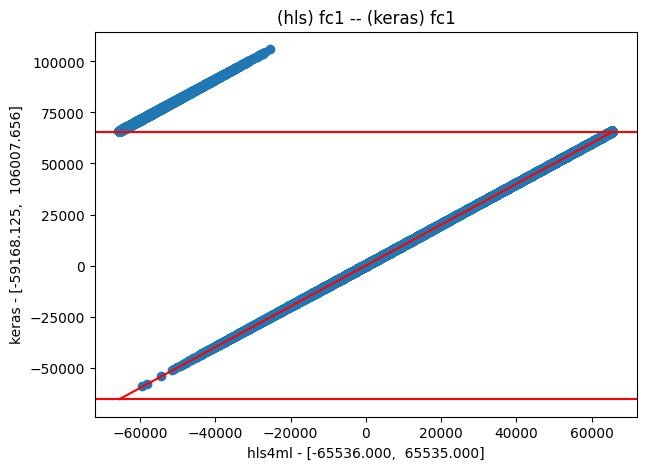

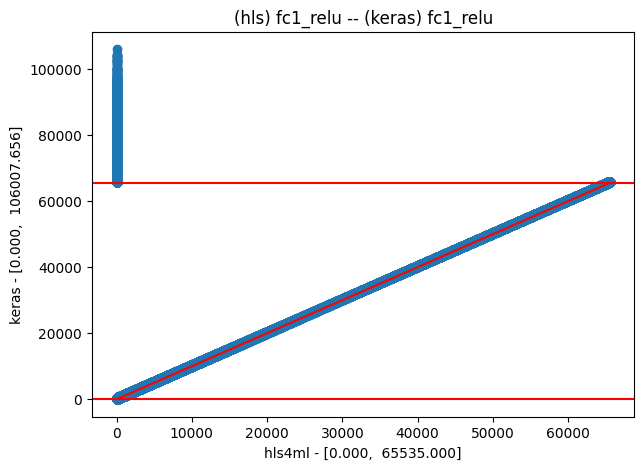

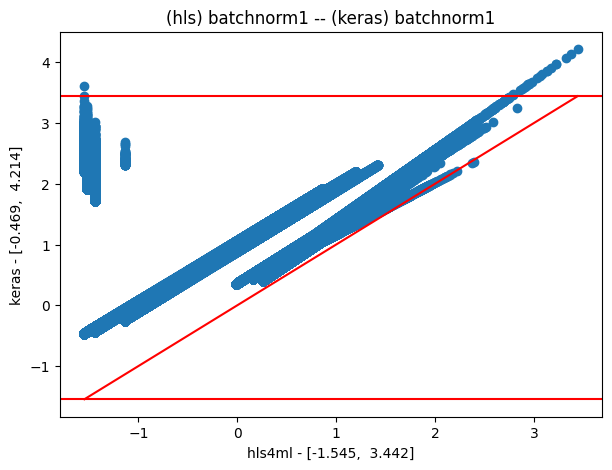

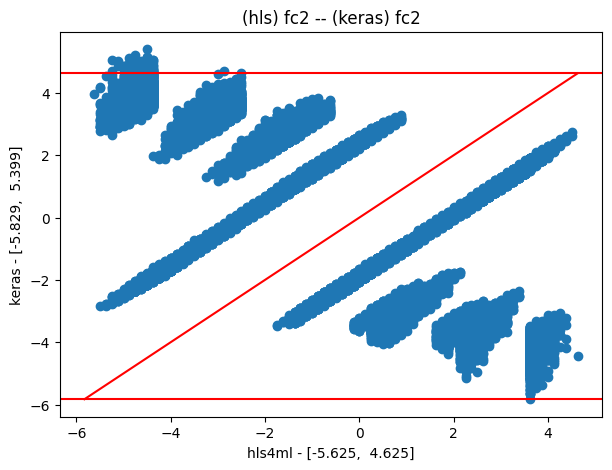

In [25]:
idx = 0

hls_layers = hls_trace.keys()
keras_layers = list(keras_trace.keys())
# keras_layers = ['q_dense_1', 'q_batch_normalization_1', 'fc2']

for hls_layer, keras_layer in zip(hls_layers, keras_layers):
    keras_layer, hls_layer = keras_trace[keras_layer], hls_trace[hls_layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'Layer(s): {list(hls_trace.keys())[idx]}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {list(hls_trace.keys())[idx]} -- (keras) {list(keras_trace.keys())[idx]}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},  {hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},  {onnx_max:.3f}]')
        plt.yscale('linear')
        idx += 1
    except Exception as e:
        print(e)


## Synthesize 

In [26]:
reports = hls_model.build(
    csim=False,
    synth=True,
    cosim=False,
    export=False,
    vsynth=True,
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1.1 (64-bit)
  **** SW Build 2960000 on Wed Aug  5 22:57:21 MDT 2020
  **** IP Build 2956692 on Thu Aug  6 01:41:30 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'thorin' (Linux_x86_64 version 5.14.0-1048-oem) on Fri Oct 04 08:20:42 PDT 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/extras/home/gdg/research/projects/quantum/qick_dev/submodules/ml-quantum-readout/hls4ml_projects/sl-100_ws-400_date-20230529'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/extras/home/gdg/research/projects/quantum/qick_dev/submodules/ml-quantum-readout/hls4ml_projects/sl-100_ws-

## Check the report

In [27]:
#print(reports)

print('HLS')
print('   BRAM {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['CSynthesisReport']['BRAM_18K']), int(reports['CSynthesisReport']['AvailableBRAM_18K']), int(reports['CSynthesisReport']['BRAM_18K'])*100/int(reports['CSynthesisReport']['AvailableBRAM_18K'])))
print('    DSP {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['CSynthesisReport']['DSP']), int(reports['CSynthesisReport']['AvailableDSP']), int(reports['CSynthesisReport']['DSP'])*100/int(reports['CSynthesisReport']['AvailableDSP'])))
print('     FF {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['CSynthesisReport']['FF']), int(reports['CSynthesisReport']['AvailableFF']), int(reports['CSynthesisReport']['FF'])*100/int(reports['CSynthesisReport']['AvailableFF'])))
print('    LUT {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['CSynthesisReport']['LUT']), int(reports['CSynthesisReport']['AvailableLUT']), int(reports['CSynthesisReport']['LUT'])*100/int(reports['CSynthesisReport']['AvailableLUT'])))
print('SYN')
print('   BRAM {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['VivadoSynthReport']['BRAM_18K']), int(reports['CSynthesisReport']['AvailableBRAM_18K']), int(reports['VivadoSynthReport']['BRAM_18K'])*100/int(reports['CSynthesisReport']['AvailableBRAM_18K'])))
print('    DSP {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['VivadoSynthReport']['DSP48E']), int(reports['CSynthesisReport']['AvailableDSP']), int(reports['VivadoSynthReport']['DSP48E'])*100/int(reports['CSynthesisReport']['AvailableDSP'])))
print('     FF {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['VivadoSynthReport']['FF']), int(reports['CSynthesisReport']['AvailableFF']), int(reports['VivadoSynthReport']['FF'])*100/int(reports['CSynthesisReport']['AvailableFF'])))
print('    LUT {:8d} ({:8d}, {:6.2f}%)'.format(int(reports['VivadoSynthReport']['LUT']), int(reports['CSynthesisReport']['AvailableLUT']), int(reports['VivadoSynthReport']['LUT'])*100/int(reports['CSynthesisReport']['AvailableLUT'])))

HLS
   BRAM       22 (    2160,   1.02%)
    DSP      129 (    4272,   3.02%)
     FF    77642 (  850560,   9.13%)
    LUT   102155 (  425280,  24.02%)
SYN
   BRAM        0 (    2160,   0.00%)
    DSP      134 (    4272,   3.14%)
     FF    47039 (  850560,   5.53%)
    LUT    22276 (  425280,   5.24%)


In [28]:
df_hls = pd.DataFrame([reports['CSynthesisReport']])
hls_csv_file = 'hls_report.csv'
hls_csv_file_exists = os.path.isfile(hls_csv_file)
df_hls.to_csv(hls_csv_file, mode='a', index=False, header=not hls_csv_file_exists)
df_hls_loaded = pd.read_csv(hls_csv_file)
df_hls_loaded

,TargetClockPeriod,EstimatedClockPeriod,BestLatency,WorstLatency,IntervalMin,IntervalMax,BRAM_18K,DSP,FF,LUT,URAM,AvailableBRAM_18K,AvailableDSP,AvailableFF,AvailableLUT,AvailableURAM
0,3.22,2.768,874,875,875,876,645,106,196393,205339,0,2160,4272,850560,425280,80
1,3.22,2.799,832,833,833,834,757,610,909414,1142446,0,2160,4272,850560,425280,80
2,3.22,2.768,5601,5601,5602,5602,67,410,86340,106817,0,2160,4272,850560,425280,80
3,3.22,2.768,5601,5601,5602,5602,67,410,86340,106817,0,2160,4272,850560,425280,80
4,3.22,2.768,5601,5601,5602,5602,67,410,86340,106817,0,2160,4272,850560,425280,80
5,3.22,2.768,5601,5601,5602,5602,67,401,86442,107039,0,2160,4272,850560,425280,80
6,3.22,2.768,5601,5601,5602,5602,22,129,77673,102178,0,2160,4272,850560,425280,80
7,3.22,2.768,5601,5601,5602,5602,22,129,77642,102155,0,2160,4272,850560,425280,80


In [29]:
df_syn = pd.DataFrame([reports['VivadoSynthReport']])
syn_csv_file = 'syn_report.csv'
syn_csv_file_exists = os.path.isfile(syn_csv_file)
df_syn.to_csv(syn_csv_file, mode='a', index=False, header=not syn_csv_file_exists)
df_syn_loaded = pd.read_csv(syn_csv_file)
df_syn_loaded

,LUT,FF,BRAM_18K,URAM,DSP48E
0,89713,58349,156,0,106
1,74760,63230,156,0,610
2,28193,46864,0,0,310
3,28193,46864,0,0,310
4,28193,46864,0,0,310
5,30325,48323,0,0,407
6,22875,47005,0,0,135
7,22276,47039,0,0,134


In [30]:
hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in ../hls4ml_projects/sl-100_ws-400_date-20230529/NN_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'NN_axi'
* Date:           Fri Oct  4 08:30:01 2024

* Version:        2020.1.1 (Build 2951007 on Wed Aug 05 23:24:06 MDT 2020)
* Project:        NN_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu49dr-ffvf1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 3.22 ns | 2.768 ns |   0.40 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+------+------+----------+
    |  Latency (cycles) |   Latency (absolute)  |   Interval  | Pipeline |
    |   min   |   max   |    min    |    max    |  min |  max |   Type   |
    +------

In [70]:
!echo "$PWD/../hls4ml_projects/"
!ls "$PWD/../hls4ml_projects/"

/extras/home/gdg/research/projects/quantum/qick_dev/submodules/ml-quantum-readout/notebooks/../hls4ml_projects/
sl-100_ws-400_date-20230529	    sl-100_ws-400_date-20240528
sl-100_ws-400_date-20230529.tar.gz  sl-100_ws-400_date-20240528.tar.gz
